# Training

### Preparing darknet

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To make calling google drive easier
!ln -s /content/drive/MyDrive/ /mydrive

In [ ]:
# Cloning DarkNet
!git clone https://github.com/AlexeyAB/darknet &> /dev/null

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [ ]:
# make darknet (build)
!make &> /dev/null

In [ ]:
# Copy training file from google drive
!cp /mydrive/face_yolo_1/yolo_train_data.zip ../

In [ ]:
# Unzip training file
!unzip ../yolo_train_data.zip -d data/

In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/face_yolo_1/yolov3_custom.cfg ./cfg

In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/face_yolo_1//object.names ./data
!cp /mydrive/face_yolo_1//object.data  ./data


In [ ]:
# py script for generating train txt data
!cp /mydrive/face_yolo_1/generate_train.py ./

In [ ]:
!python generate_train.py

In [ ]:
# Function to show images
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
# Download pretrained darknet weights from pjreddie
!wget http://pjreddie.com/media/files/darknet53.conv.74

URL transformed to HTTPS due to an HSTS policy
--2021-05-15 15:30:39--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.1’

darknet53.conv.74.1 100%[===================>] 154.96M  20.9MB/s    in 7.8s    

2021-05-15 15:30:47 (20.0 MB/s) - ‘darknet53.conv.74.1’ saved [162482580/162482580]



In [ ]:
# Retrain from scratch
!./darknet detector train data/object.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

In [ ]:
# Continue training with pre-trained weights
!./darknet detector train data/object.data cfg/yolov3_custom.cfg /mydrive/face_yolo_1/backup2/yolov3_custom_last.weights -dont_show

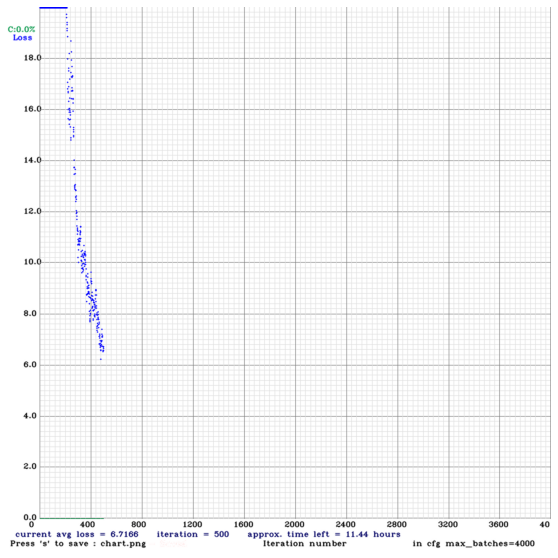

In [ ]:
# Show loss while training
imShow('chart.png')

### Test after training

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


/content/darknet/cfg
/content/darknet


In [ ]:
!ls

3rdparty	DarknetConfig.cmake.in	json_mjpeg_streams.sh  results
backup		darknet_images.py	LICENSE		       scripts
build		darknet.py		Makefile	       src
build.ps1	darknet_video.py	net_cam_v3.sh	       vcpkg.json
cfg		data			net_cam_v4.sh	       video_yolov3.sh
cmake		image_yolov3.sh		obj		       video_yolov4.sh
CMakeLists.txt	image_yolov4.sh		predictions.jpg
darknet		include			README.md


In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/object.data cfg/yolov3_custom.cfg /mydrive/face_yolo_1/backup/yolov3_custom_last.weights /mydrive/images/tesktp.jpg -thresh 0.3
imShow('predictions.jpg')

# Test

In [ ]:
# Import cv2
import cv2 as cv

In [ ]:
labelpath = '/mydrive/face_yolo_1/object.names'
cfgpath = '/mydrive/face_yolo_1/yolov3_custom.cfg'
weightpath = '/content/drive/MyDrive/face_yolo_1/backup/yolov3_custom_last.weights'

with open(labelpath, 'r') as l : 
    classes = [line.strip() for line in l.readlines()]

In [ ]:
# Load yolov3 net using cv
net = cv.dnn.readNet(weightpath,cfgpath)

In [ ]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] -1] for i in net.getUnconnectedOutLayers()]

In [ ]:
# Test using images
from google.colab.patches import cv2_imshow
# Read image
img = cv.imread('/content/ktp6.png')
# Convert image to inputs for the yolov3 neural network
blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]
# Input
net.setInput(blob)
outputs = net.forward(output_layers)

In [ ]:
# Get bounding boxes from image
import numpy as np
boxes = []
confidences = []
classIDs = []
h,w = img.shape[:2]

for output in outputs:
    for detection in output:
        scores = detection[5:]
        # print(f'scores={scores}')
        classID = np.argmax(scores)
        # print(f'classID = {classID}')
        confidence = scores[classID]
        # print(f'confidence = {confidence}') 
        if confidence > 0.5:
            print(f'confidence = {confidence}')
            # print(f'scores = {scores}')
            print(f'detection = {detection}')
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

confidence = 0.9935817122459412
detection = [0.81455255 0.43807942 0.15115336 0.31826228 0.9935887  0.9935817 ]


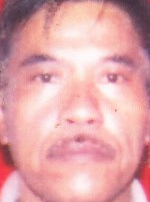

In [ ]:
# Show cropped faces
indices = cv.dnn.NMSBoxes(boxes,confidences,0.5,0.6, top_k=1)

if len(indices) > 0  : # Detected an object
    for i in indices.flatten() : 
        (x,y) = (boxes[i][0], boxes[i][1])
        (w,h) = (boxes[i][2], boxes[i][3])
        crop_img = img[y:y+h, x:x+w]
        cv2_imshow(crop_img)

# Convert to protobuf and then tflite

In [ ]:
# convert to pb
!flow --model cfg/yolov3_custom.cfg --load /mydrive/face_yolo_1/backup/yolov3_custom_last.weights --savepb

/bin/bash: flow: command not found
